# Cleaning data 

In [21]:
!pip3 install langdetect

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 981 kB 2.8 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=994442 sha256=b5c316517a24eba4818bd5065d0303555f701d6feb68d7043853323591a4e9bf
  Stored in directory: /home/david/.cache/pip/wheels/53/88/5d/b239dc55d773b01fdd2059606b1a8f4b64548848b8f6e381c3
Successfully built langdetect


In [30]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sn
from langdetect import detect, detect_langs

In [4]:
with open('../DATA/goodread_reviews_dataset.json', 'r') as f:
    data = json.load(f)

In [5]:
df = pd.DataFrame(data).T
print(len(df))
df.head()

27972


,review,grade
0,,liked it
1,Thought provoking.Life shattering.Gut wrenchin...,it was amazing
2,I finally finished reading this book. Finally ...,did not like it
3,"Never Let Me Go, Kazuo Ishiguro's Examination ...",it was amazing
4,Never Let Me Go by Kazuo Ishiguro is an intere...,it was ok


### How many are empty reviews?

In [6]:
df.review[df.review==''].count()

1413

In [7]:
df = df.drop(df[df['review']==''].index)

### Reviews that are not in english

In [8]:
def lang(text):
    try:
        lan = detect(text)
        return lan
    except:
        return None
    
    
df['lang'] = df.review.apply(lang)

In [9]:
df_clean = df[df['lang']=='en']

In [10]:
print(len(df_clean))
df_clean.head()

25680


,review,grade,lang
1,Thought provoking.Life shattering.Gut wrenchin...,it was amazing,en
2,I finally finished reading this book. Finally ...,did not like it,en
3,"Never Let Me Go, Kazuo Ishiguro's Examination ...",it was amazing,en
4,Never Let Me Go by Kazuo Ishiguro is an intere...,it was ok,en
5,Know when to hold them and know when to fold t...,did not like it,en


In [11]:
def get_score(grade):
    d = {'it was amazing':4, 'really liked it':3, 'liked it':2, 'it was ok':1, 'did not like it':0}
    return d[grade]
df_clean['score'] = df_clean.grade.apply(get_score)    

/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


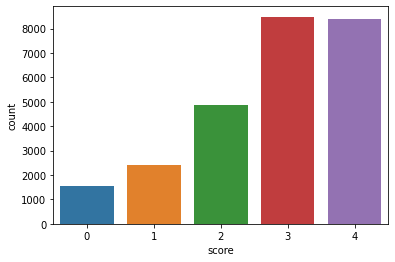

In [12]:
sn.countplot(df_clean.score)

Classes are very biased. Let's group them in two versions, one trying to get a good number of observations, a second one trying to get really polarized data (on spite of reducing the data by quite a lot):

In [26]:
def get_sentiment(score):
    if score <= 1:
        return -1
    elif score==2:
        return 0
    else:
        return 1
    
def get_sentiment_polar(score):
    if score == 0:
        return -1
    elif score==2:
        return 0
    elif score==4:
        return 1
    else: score==None
    
df_clean['sentiment'] = df_clean.score.apply(get_sentiment)
df_clean['sentiment_polar'] = df_clean.score.apply(get_sentiment_polar)

/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


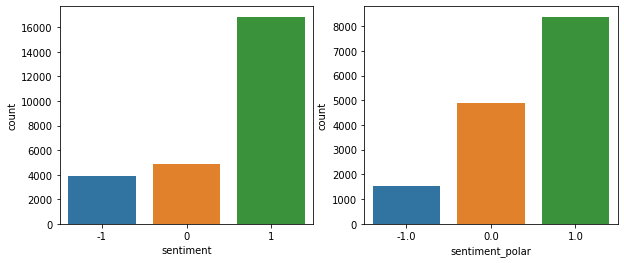

In [36]:
f, axes = plt.subplots(1, 2, figsize=(10,4))
sn.countplot(df_clean.sentiment, ax=axes[0])
sn.countplot(df_clean.sentiment_polar, ax=axes[1])

They are still very biased. So let's subset the data with all the negative and neutral reviews and a balance random sample of positive reviews. First for the not polarized one:

In [38]:
print(len(df_clean[df_clean['sentiment']==-1]), 'negative reviews')
print(len(df_clean[df_clean['sentiment']==0]), 'neutral reviews')
print(len(df_clean[df_clean['sentiment']==1]), 'positive reviews')

3939 negative reviews
4882 neutral reviews
16859 positive reviews


In [48]:
positive = df_clean[df_clean['sentiment']==1].sample(4800)
negative_neutral = df_clean[df_clean['sentiment']!=1]

In [49]:
df_clean_balance = pd.concat([positive, negative_neutral])

In [50]:
print(len(df_clean_balance))
df_clean_balance

13621


,review,grade,lang,score,sentiment,sentiment_polar
9821,"Well, he may not be scared but call me utterly...",really liked it,en,3,1,NaN
16973,"This is a five-star book, to be sure.My rating...",really liked it,en,3,1,NaN
20007,Terrific psychological thriller debut by this ...,really liked it,en,3,1,NaN
19703,Margaret Atwood is the Dystopian Queen 👑 and s...,it was amazing,en,4,1,1.0
23307,Protagonist Quoyle is a kind man born into an ...,really liked it,en,3,1,NaN
...,...,...,...,...,...,...
27962,"Extremely well written, solid story, solid nar...",liked it,en,2,0,0.0
27965,Hippies traipsing around Morocco with no money...,liked it,en,2,0,0.0
27966,A pleasurable read - sweet and atmospheric. 3....,liked it,en,2,0,0.0
27967,"It's so boring, the reviews said that it's so ...",did not like it,en,0,-1,-1.0


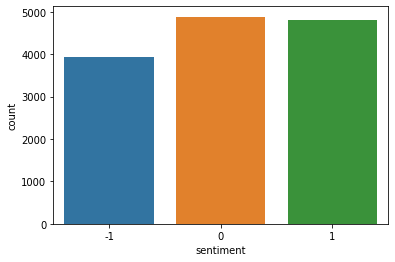

In [51]:
sn.countplot(df_clean_balance.sentiment)

In [44]:
df_clean_balance.to_csv('../DATA/goodreads_reviews_clean.csv', index=False)

Then for the polarized data:

In [45]:
print(len(df_clean[df_clean['sentiment_polar']==-1]), 'negative reviews')
print(len(df_clean[df_clean['sentiment_polar']==0]), 'neutral reviews')
print(len(df_clean[df_clean['sentiment_polar']==1]), 'positive reviews')

1547 negative reviews
4882 neutral reviews
8374 positive reviews


In [52]:
positive_plr = df_clean[df_clean['sentiment_polar']==1].sample(2000)
neutral_plr = df_clean[df_clean['sentiment_polar']==0].sample(2000)
negative_plr = df_clean[df_clean['sentiment_polar']==-1]

In [53]:
df_clean_balance_plr = pd.concat([positive_plr, negative_plr, neutral_plr])

In [55]:
print(len(df_clean_balance_plr))
df_clean_balance_plr

5547


,review,grade,lang,score,sentiment,sentiment_polar
5287,I consider this book to be truly wonderful. My...,it was amazing,en,4,1,1.0
15116,"One of the hardest books for me to read, but v...",it was amazing,en,4,1,1.0
4975,Newsflash: I have a new entry into my Top Ten ...,it was amazing,en,4,1,1.0
26201,"Read years ago, but still remember this powerf...",it was amazing,en,4,1,1.0
23605,I first read Trainspotting when I was in colle...,it was amazing,en,4,1,1.0
...,...,...,...,...,...,...
3722,"Great easy quick read, liked it a lot.Ackroyd ...",liked it,en,2,0,0.0
25376,If I had not read Sebald's later inestimable m...,liked it,en,2,0,0.0
8478,Do not read the Introduction before reading th...,liked it,en,2,0,0.0
16734,"Like his previous book ""The Peron Novel"", quit...",liked it,en,2,0,0.0


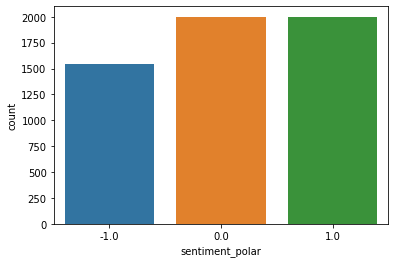

In [58]:
sn.countplot(df_clean_balance_plr.sentiment_polar)

In [59]:
df_clean_balance_plr.to_csv('../DATA/goodreads_reviews_clean_polarized.csv', index=False)